In [ ]:
from pathlib import Path
import pandas as pd

candidates = [
    Path(r"G:\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\Google Drive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path(r"G:\GoogleDrive\My Drive\eye_project\processed\splits_strict_10cls_new"),
    Path.home() / "Google Drive" / "My Drive" / "eye_project" / "processed" / "splits_strict_10cls_new",
]

FOUND = None
for p in candidates:
    if (p / "train.csv").exists() and (p / "val.csv").exists() and (p / "test.csv").exists():
        FOUND = p
        break

if FOUND is None:
    search_drives = ["G", "D", "E", "F", "H", "I"]
    for d in search_drives:
        root = Path(f"{d}:/")
        if not root.exists():
            continue
        try:

            for hit in root.rglob("eye_project/processed/splits_strict_10cls_new/train.csv"):

                folder = hit.parent
                if (folder / "val.csv").exists() and (folder / "test.csv").exists():
                    FOUND = folder
                    break
        except Exception:
            pass
        if FOUND is not None:
            break

if FOUND is None:
    raise FileNotFoundError(
        "Could not locate 'eye_project/processed/splits_strict_10cls_new' on this machine.\n"
        "Please check where Google Drive is mounted (e.g., G:\\My Drive\\...) and update SRC path."
    )

print("✅ Found splits folder at:", FOUND)

train_df = pd.read_csv(FOUND / "train.csv")
val_df   = pd.read_csv(FOUND / "val.csv")
test_df  = pd.read_csv(FOUND / "test.csv")

print("Train/Val/Test shapes:", train_df.shape, val_df.shape, test_df.shape)
print("Sample rows:")
display(train_df.head(3))

SRC_ROOT = FOUND.parents[1]
SRC_RAW  = SRC_ROOT / "raw"
SRC_PROC = SRC_ROOT / "processed"
print("\nSRC_ROOT:", SRC_ROOT)
print("SRC_RAW :", SRC_RAW)
print("SRC_PROC:", SRC_PROC)


✅ Found splits folder at: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project\processed\splits_strict_10cls_new
Train/Val/Test shapes: (768, 15) (165, 15) (165, 15)
Sample rows:


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_317,317,rfmid1_train,DN,0,0,0,0,0,0,0,0,0,1,/content/drive/MyDrive/eye_project/raw/RFMiD/T...
1,rfmid2_train_625,625,rfmid2_train,DR,0,0,0,0,1,0,0,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD2_...
2,rfmid1_test_16,16,NaN,ERM,0,0,0,0,0,0,1,0,0,0,/content/drive/MyDrive/eye_project/raw/RFMiD/T...



SRC_ROOT: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project
SRC_RAW : G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project\raw
SRC_PROC: G:\.shortcut-targets-by-id\1l_nZ39-pdNyuc1s9L8uEWFZrTOFhw1Nq\eye_project\processed


In [ ]:
import os, shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm

assert FOUND is not None, "Run the previous cell first to locate your splits."

DST_ROOT   = Path(r"C:\datasets\eye_project")
SRC_RAW    = SRC_ROOT / "raw"
SRC_SPLITS = FOUND

DST_RAW    = DST_ROOT / "raw"
DST_PROC   = DST_ROOT / "processed"
DST_SPLITS = DST_PROC / "splits_strict_10cls_new"

for p in [DST_ROOT, DST_RAW, DST_PROC, DST_SPLITS]:
    p.mkdir(parents=True, exist_ok=True)

# Reload split CSVs (from FOUND)
train_df = pd.read_csv(SRC_SPLITS / "train.csv")
val_df   = pd.read_csv(SRC_SPLITS / "val.csv")
test_df  = pd.read_csv(SRC_SPLITS / "test.csv")

# Normalize any lingering Colab paths → Drive paths
def to_drive_prefix(p: str) -> str:
    return str(p).replace("/content/drive/MyDrive/eye_project", str(SRC_ROOT))

for df in (train_df, val_df, test_df):
    df["img_path"] = df["img_path"].astype(str).apply(to_drive_prefix)

# Collect unique image paths that actually exist
all_paths = pd.concat([train_df["img_path"], val_df["img_path"], test_df["img_path"]]).unique().tolist()
all_paths = [p for p in all_paths if Path(p).exists()]
print(f"Total images to copy: {len(all_paths):,}")

# Helper: path relative to SRC_RAW (preserve RFMiD / RFMiD2_0 structure)
def rel_under_raw(full_path: Path) -> Path:
    try:
        return full_path.relative_to(SRC_RAW)
    except Exception:
        parts = full_path.parts
        if "raw" in parts:
            i = parts.index("raw")
            return Path(*parts[i+1:])
        return Path(full_path.name)

# Copy images
copied, skipped = 0, 0
for s in tqdm(all_paths, desc="Copying images"):
    src = Path(s)
    rel = rel_under_raw(src)
    dst = DST_RAW / rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)
        copied += 1
    else:
        skipped += 1

print(f"Images copied: {copied:,}  (already existed: {skipped:,})")

# Write local CSVs with C:\datasets\... prefix
def to_local_prefix(p: str) -> str:
    return str(p).replace(str(SRC_ROOT), str(DST_ROOT))

def write_local(df: pd.DataFrame, name: str):
    out = df.copy()
    out["img_path"] = out["img_path"].astype(str).apply(to_local_prefix)
    out.to_csv(DST_SPLITS / name, index=False)

write_local(train_df, "train_local.csv")
write_local(val_df,   "val_local.csv")
write_local(test_df,  "test_local.csv")

print("\n✅ Done. Local CSVs at:", DST_SPLITS)

Total images to copy: 1,098


Copying images: 100%|██████████| 1098/1098 [37:10<00:00,  2.03s/it]

Images copied: 1,098  (already existed: 0)

✅ Done. Local CSVs at: C:\datasets\eye_project\processed\splits_strict_10cls_new


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

ROOT_LOCAL = Path(r"C:\datasets\eye_project")
PROC_LOCAL = ROOT_LOCAL / "processed" / "splits_strict_10cls_new"

TRAIN_CSV = PROC_LOCAL / "train_local.csv"
VAL_CSV   = PROC_LOCAL / "val_local.csv"
TEST_CSV  = PROC_LOCAL / "test_local.csv"

CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
print("Train/Val/Test:", train_df.shape, val_df.shape, test_df.shape)
train_df.head(3)

Device: cuda
Train/Val/Test: (768, 15) (165, 15) (165, 15)


,UID,ID,source,label,AION,ARMD,BRVO,CRVO,DR,MHL,ERM,ODC,RPEC,DN,img_path
0,rfmid1_train_317,317,rfmid1_train,DN,0,0,0,0,0,0,0,0,0,1,C:\datasets\eye_project/raw/RFMiD/Training_Set...
1,rfmid2_train_625,625,rfmid2_train,DR,0,0,0,0,1,0,0,0,0,0,C:\datasets\eye_project/raw/RFMiD2_0/train/625...
2,rfmid1_test_16,16,NaN,ERM,0,0,0,0,0,0,1,0,0,0,C:\datasets\eye_project/raw/RFMiD/Test_Set/Tes...


In [ ]:
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision import transforms
from PIL import Image
import torch

# Inception-v4: 299x299, ImageNet normalization
transform_inc = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class FundusDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        assert "img_path" in self.df.columns, "img_path missing"
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(CLASS_TO_IDX[row["label"]], dtype=torch.long)

def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    return default_collate(batch) if len(batch) else (torch.empty(0), torch.empty(0, dtype=torch.long))

BATCH_SIZE = 32   # if OOM, reduce to 16
PIN_MEMORY = torch.cuda.is_available()

train_ds = FundusDataset(train_df, transform_inc)
val_ds   = FundusDataset(val_df,   transform_inc)
test_ds  = FundusDataset(test_df,  transform_inc)  # for later eval

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=PIN_MEMORY, collate_fn=safe_collate)

xb, yb = next(iter(train_dl))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # expect (32, 3, 299, 299), (32,)

Batch shapes: (32, 3, 299, 299) (32,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model("inception_v4", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("Model ready on:", DEVICE)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--timm--inception_v4.tf_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model ready on: cuda


In [ ]:
import time, json
from pathlib import Path

EPOCHS = 50
MODEL_DIR = ROOT_LOCAL / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
INC_BEST = MODEL_DIR / "inception_v4_best.pth"
INC_HIST = MODEL_DIR / "inception_v4_history.json"

def run_epoch(model, dl, optimizer, criterion, device, train=True):
    if train: model.train()
    else:     model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    if train:
        for xb, yb in dl:
            if xb.nelement() == 0: continue
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            total_correct += (out.argmax(1) == yb).sum().item()
            total_samples += xb.size(0)
    else:
        with torch.no_grad():
            for xb, yb in dl:
                if xb.nelement() == 0: continue
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_loss += loss.item() * xb.size(0)
                total_correct += (out.argmax(1) == yb).sum().item()
                total_samples += xb.size(0)

    return (total_loss / max(1,total_samples),
            total_correct / max(1,total_samples))

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time_sec": []}

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    ep_t0 = time.time()
    tr_loss, tr_acc = run_epoch(model, train_dl, optimizer, criterion, DEVICE, train=True)
    val_loss, val_acc = run_epoch(model, val_dl,   optimizer, criterion, DEVICE, train=False)
    ep_time = time.time() - ep_t0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["epoch_time_sec"].append(ep_time)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Epoch time: {ep_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), INC_BEST)

t_total = time.time() - t0
print(f"\nTraining finished in {t_total/60:.2f} min")
print(f"Best validation accuracy: {best_val_acc:.4f}")
with open(INC_HIST, "w") as f:
    json.dump(history, f, indent=2)

print("Saved best model  →", INC_BEST)
print("Saved history     →", INC_HIST)


Epoch 01/50 | Train Loss: 1.6587, Train Acc: 0.4935 | Val Loss: 1.4560, Val Acc: 0.5455 | Epoch time: 89.5s
Epoch 02/50 | Train Loss: 0.8434, Train Acc: 0.7487 | Val Loss: 1.0525, Val Acc: 0.6727 | Epoch time: 88.8s
Epoch 03/50 | Train Loss: 0.4571, Train Acc: 0.8841 | Val Loss: 0.8965, Val Acc: 0.7030 | Epoch time: 89.3s
Epoch 04/50 | Train Loss: 0.2683, Train Acc: 0.9284 | Val Loss: 0.9666, Val Acc: 0.7212 | Epoch time: 89.2s
Epoch 05/50 | Train Loss: 0.1529, Train Acc: 0.9635 | Val Loss: 0.7940, Val Acc: 0.7818 | Epoch time: 89.2s
Epoch 06/50 | Train Loss: 0.0970, Train Acc: 0.9831 | Val Loss: 1.0162, Val Acc: 0.7030 | Epoch time: 88.7s
Epoch 07/50 | Train Loss: 0.1024, Train Acc: 0.9779 | Val Loss: 0.9224, Val Acc: 0.7091 | Epoch time: 89.6s
Epoch 08/50 | Train Loss: 0.0646, Train Acc: 0.9870 | Val Loss: 1.1149, Val Acc: 0.6970 | Epoch time: 88.6s
Epoch 09/50 | Train Loss: 0.0661, Train Acc: 0.9805 | Val Loss: 1.1565, Val Acc: 0.6970 | Epoch time: 89.0s
Epoch 10/50 | Train Loss: 0.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


C:\Users\admin\AppData\Local\Temp\ipykernel_19936\3929847620.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(INC_BEST, map_location=DEV

✅ Loaded best model from C:\datasets\eye_project\models\inception_v4_best.pth

✅ Test Accuracy: 0.8182

=== Classification Report (per class) ===
              precision    recall  f1-score   support

        AION     0.6667    0.6667    0.6667         3
        ARMD     0.8889    0.7273    0.8000        11
        BRVO     0.8462    0.7333    0.7857        15
        CRVO     1.0000    1.0000    1.0000         8
          DR     0.8846    0.9718    0.9262        71
         MHL     0.0000    0.0000    0.0000         2
         ERM     0.0000    0.0000    0.0000         2
         ODC     0.9545    0.8077    0.8750        26
        RPEC     0.0000    0.0000    0.0000         3
          DN     0.5517    0.6667    0.6038        24

    accuracy                         0.8182       165
   macro avg     0.5793    0.5573    0.5657       165
weighted avg     0.8081    0.8182    0.8096       165



c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\admin\anaconda3\envs\rfmid\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

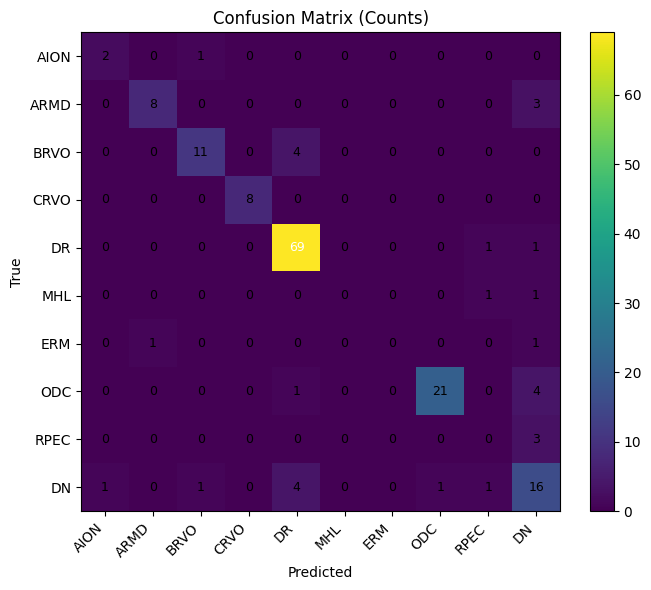


=== ROC-AUC ===
Micro-AUC: 0.9646 | Macro-AUC: 0.9190
AION: 0.9897
ARMD: 0.9339
BRVO: 0.8973
CRVO: 1.0000
DR: 0.9802
MHL: 0.8344
ERM: 0.8650
ODC: 0.9870
RPEC: 0.8107
DN: 0.8921


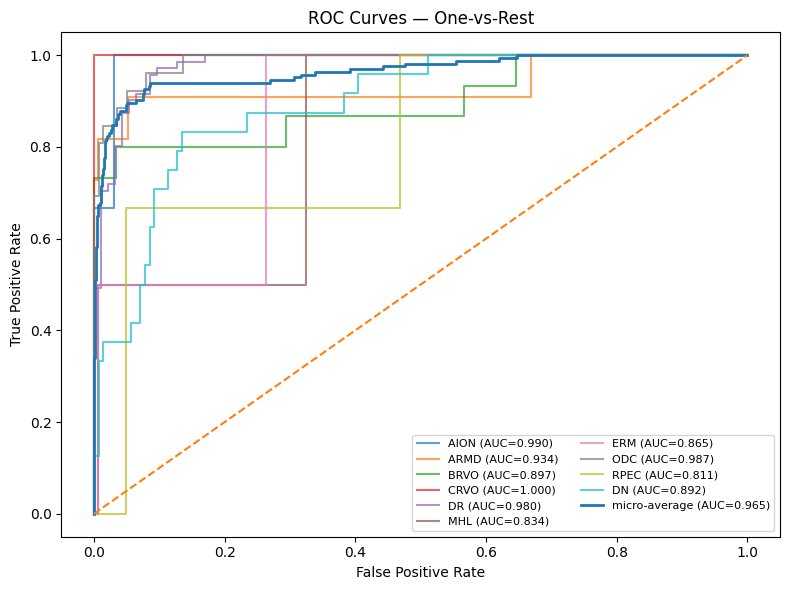

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Paths ----
MODEL_DIR = ROOT_LOCAL / "models"
INC_BEST = MODEL_DIR / "inception_v4_best.pth"  # Path to the saved model checkpoint
INC_HIST = MODEL_DIR / "inception_v4_history.json"  # Path to training history
NUM_CLASSES = len(CLASSES)  # Define your classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load the Best Model ----
model = timm.create_model("inception_v4", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(INC_BEST, map_location=DEVICE))
model.eval()  # Set to evaluation mode
print(f"✅ Loaded best model from {INC_BEST}")

# ---- Inference on the Test Set ----
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:  # Assuming test_dl is the DataLoader for your test set
        if xb.nelement() == 0:
            continue
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        probs  = F.softmax(logits, dim=1).cpu().numpy()  # Apply softmax to get probabilities
        preds  = probs.argmax(axis=1)

        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(yb.cpu().numpy())  # Moving labels to CPU for storing in numpy array

# Concatenate the results into single arrays
y_prob = np.concatenate(y_prob, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# ---- Overall Accuracy ----
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# ---- Classification Report ----
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# ---- Confusion Matrix (with counts) ----
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_xticklabels(CLASSES, rotation=45, ha="right")
ax.set_yticklabels(CLASSES)

# Annotate counts on the matrix
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                fontsize=9, color="white" if cm[i,j] > cm.max()/2 else "black")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ---- ROC–AUC (One-vs-Rest) ----
# Binarize true labels
y_true_ovr = np.zeros((y_true.shape[0], NUM_CLASSES), dtype=int)
y_true_ovr[np.arange(y_true.shape[0]), y_true] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_ovr[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average (aggregated AUC)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ovr.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (mean AUC)
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(NUM_CLASSES)])

print("\n=== ROC-AUC ===")
print(f"Micro-AUC: {roc_auc['micro']:.4f} | Macro-AUC: {roc_auc['macro']:.4f}")
for i, cls in enumerate(CLASSES):
    print(f"{cls}: {roc_auc[i]:.4f}")

# ---- Plot ROC Curves (All classes + Micro) ----
plt.figure(figsize=(8, 6))
for i, cls in enumerate(CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.3f})", alpha=0.7)
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()



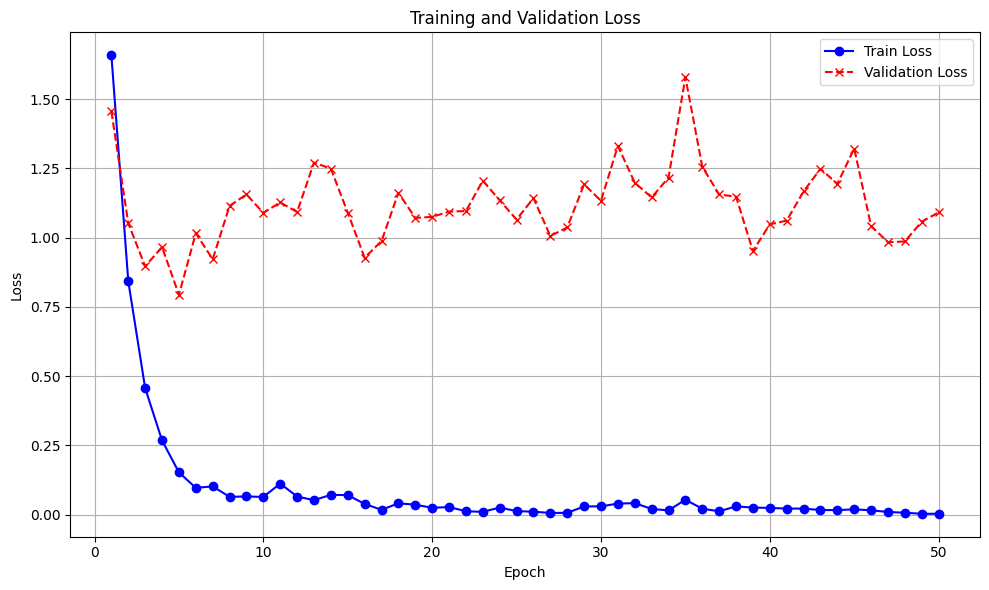

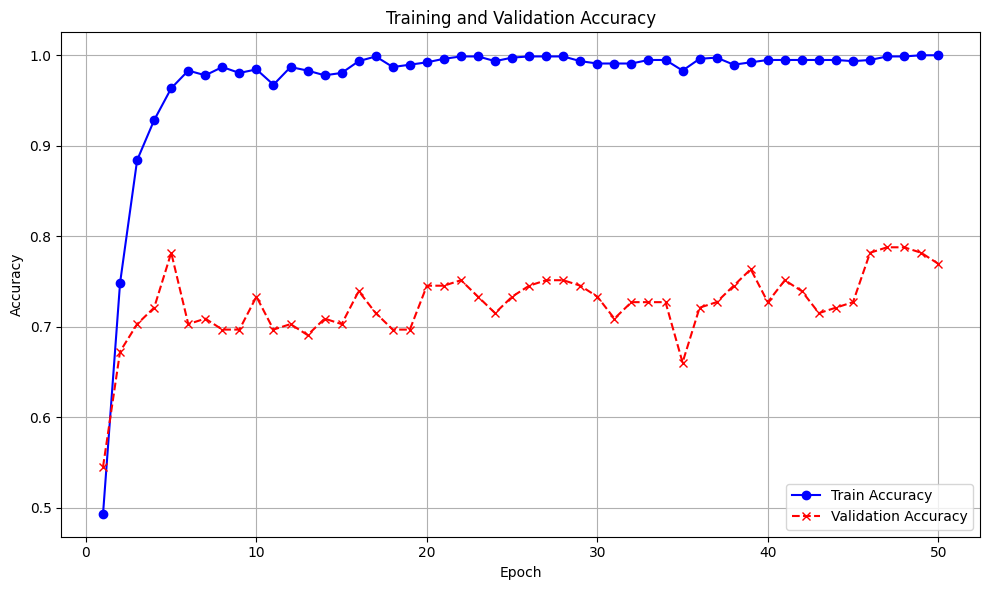

In [ ]:
import matplotlib.pyplot as plt
import json

# ---- Load Training History (if saved) ----
with open(INC_HIST, "r") as f:
    history = json.load(f)

epochs = range(1, len(history["train_loss"]) + 1)

# ---- Plot Training and Validation Loss ----
plt.figure(figsize=(10, 6))
plt.plot(epochs, history["train_loss"], label="Train Loss", color="b", linestyle='-', marker='o')
plt.plot(epochs, history["val_loss"], label="Validation Loss", color="r", linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Training and Validation Accuracy ----
plt.figure(figsize=(10, 6))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", color="b", linestyle='-', marker='o')
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", color="r", linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test rows: 165
✅ Loaded: C:\datasets\eye_project\models\inception_v4_best.pth
Explaining: C:\datasets\eye_project/raw/RFMiD/Training_Set/Training/1332.png


RISE: 100%|██████████| 32/32 [00:01<00:00, 16.06it/s]


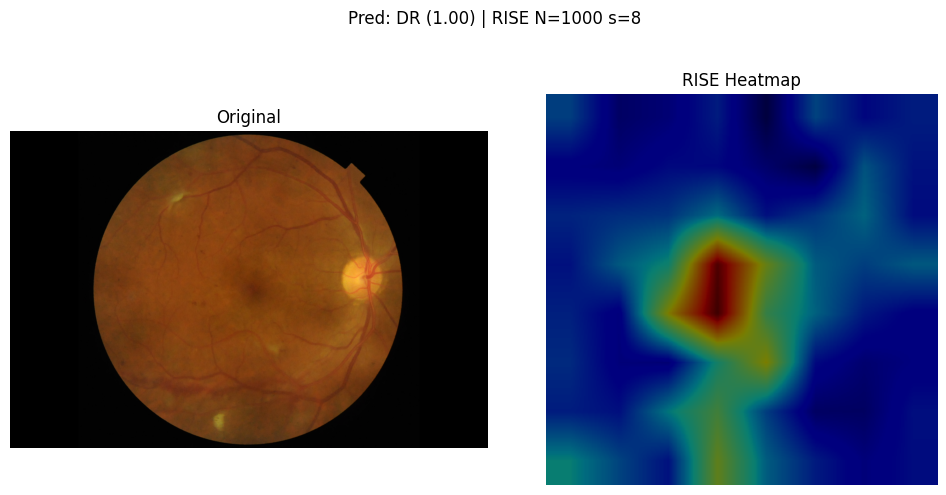

✅ Saved: C:\datasets\eye_project\models\reports\inception_v4_rise\1332_rise.png


In [ ]:
# ==== InceptionV4 RISE XAI Toolkit (Final, Fixed, Complete) ====

import numpy as np, pandas as pd, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm
from pathlib import Path
from tqdm import tqdm

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "inception_v4_best.pth"
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "inception_v4_rise"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- DATA ----------------
test_df = pd.read_csv(TEST_CSV)
print("Test rows:", len(test_df))

# ---------------- MODEL ----------------
model = timm.create_model("inception_v4", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval().to(DEVICE)
print("✅ Loaded:", CKPT_PATH)

# ---------------- PREPROCESS ----------------
def make_preproc(size=299):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
preproc_299 = make_preproc(299)

# ---------------- HELPERS ----------------
def predict_probs(pil_img, preproc=preproc_299):
    x = preproc(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1)[0].cpu().numpy()
    return x, probs, int(np.argmax(probs))

def normalize01(a):
    a = a - a.min()
    return a / (a.max() + 1e-8)

# ---------------- RISE IMPLEMENTATION ----------------
def generate_masks(N=2000, s=8, p1=0.5, input_size=(299, 299)):
    """
    Generate random binary masks for RISE.
    N: number of masks
    s: grid size (e.g. 8x8)
    p1: probability of 1s
    """
    masks = np.random.choice([0, 1], size=(N, s, s), p=[1-p1, p1]).astype(np.float32)
    upsampled = np.empty((N, *input_size), dtype=np.float32)
    for i in range(N):
        mask = Image.fromarray(masks[i])
        mask = mask.resize(input_size[::-1], resample=Image.BILINEAR)
        upsampled[i] = np.array(mask, dtype=np.float32)
    upsampled = upsampled[:, np.newaxis, :, :]  # (N, 1, H, W)
    return torch.tensor(upsampled, dtype=torch.float32)

def rise_explain(pil_img, target_idx="pred", N=1000, s=8, p1=0.5):
    x, probs, pred_idx = predict_probs(pil_img)
    tgt = pred_idx if target_idx == "pred" else int(target_idx)

    masks = generate_masks(N=N, s=s, p1=p1, input_size=x.shape[-2:]).to(DEVICE)
    sal = torch.zeros_like(x, dtype=torch.float32)

    batch_size = 32
    with torch.no_grad():
        for i in tqdm(range(0, N, batch_size), desc="RISE"):
            mb = masks[i:i+batch_size]  # (B,1,H,W)
            xm = x * mb  # masked images
            preds = F.softmax(model(xm), dim=1)[:, tgt]  # (B,)
            sal += torch.sum(preds.view(-1, 1, 1, 1) * mb, dim=0)

    sal /= N * p1
    sal = sal.squeeze().cpu().numpy()

    # Convert (3,H,W) → (H,W) by averaging color channels
    if sal.ndim == 3:
        sal = sal.mean(axis=0)

    heat = normalize01(sal)
    return probs, pred_idx, heat

# ---------------- VISUALIZATION ----------------
def panel_rise(img_path, save_prefix="rise"):
    pil = Image.open(img_path).convert("RGB")
    probs, pred_idx, heat = rise_explain(pil, N=1000, s=8, p1=0.5)
    pred_lbl, pred_conf = CLASSES[pred_idx], probs[pred_idx]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pil)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(pil)
    ax[1].imshow(heat, cmap="jet", alpha=0.5)
    ax[1].set_title("RISE Heatmap")
    ax[1].axis("off")

    fig.suptitle(f"Pred: {pred_lbl} ({pred_conf:.2f}) | RISE N=1000 s=8")
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    out = OUT_DIR / f"{Path(img_path).stem}_{save_prefix}.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", out)

# ---------------- RUN ON SAMPLE ----------------
sample = test_df.sample(1, random_state=42).iloc[0]["img_path"]
print("Explaining:", sample)
panel_rise(sample)


Test rows: 165
✅ Loaded: C:\datasets\eye_project\models\inception_v4_best.pth
Explaining: C:\datasets\eye_project/raw/RFMiD/Training_Set/Training/1332.png


RISE: 100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


Predicted class ranking:
   1.   DR → 1.000
   2. ARMD → 0.000
   3. RPEC → 0.000
   4.  MHL → 0.000
   5.  ERM → 0.000
   6.   DN → 0.000
   7. CRVO → 0.000
   8. AION → 0.000
   9.  ODC → 0.000
  10. BRVO → 0.000


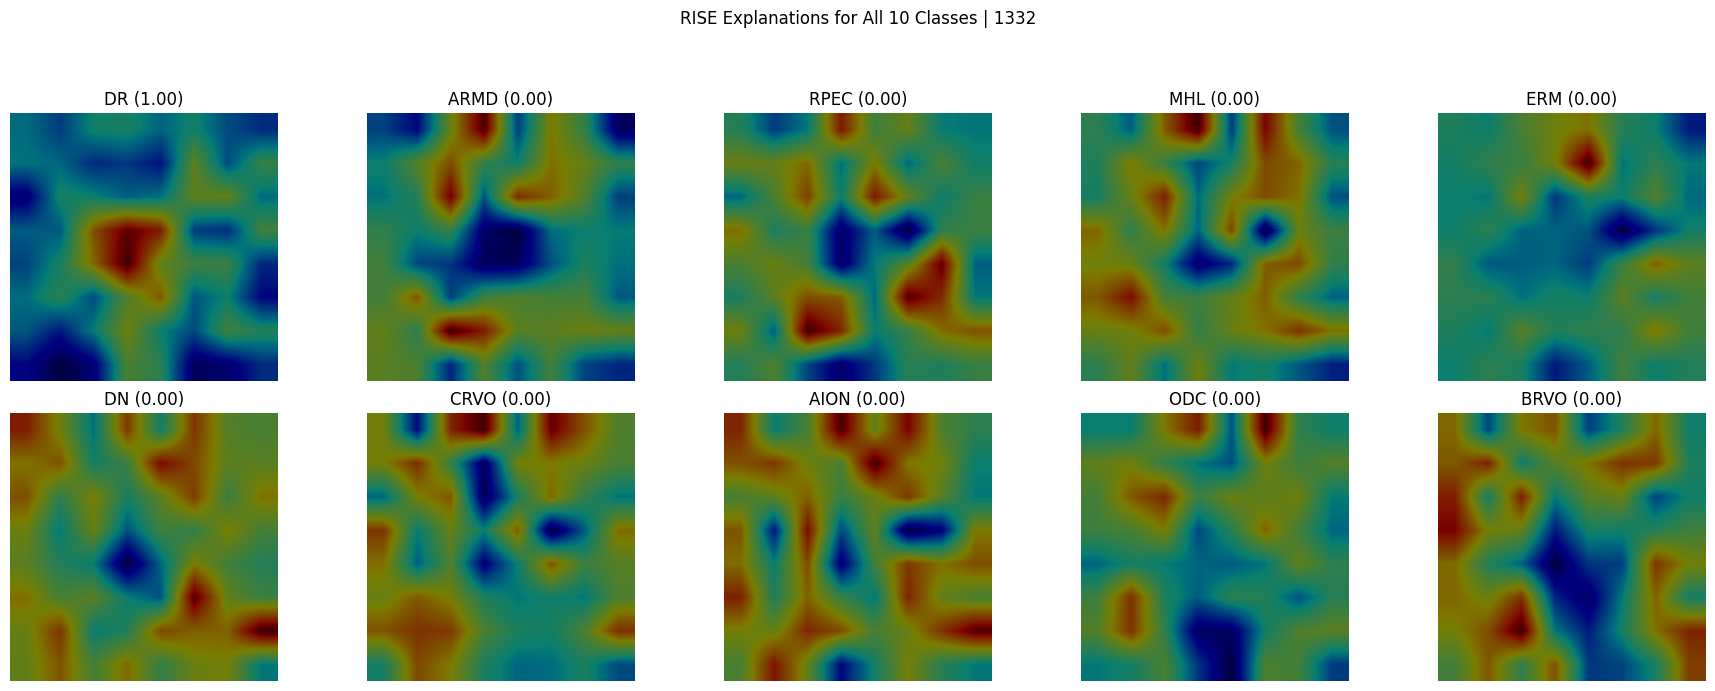

✅ Saved combined panel: C:\datasets\eye_project\models\reports\inception_v4_rise_all\1332_RISE_all_classes.png
✅ Individual heatmaps saved in: C:\datasets\eye_project\models\reports\inception_v4_rise_all


In [ ]:
# ==== InceptionV4 RISE XAI Toolkit (All 10 Classes, Fixed) ====

import numpy as np, pandas as pd, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm
from pathlib import Path
from tqdm import tqdm

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "inception_v4_best.pth"
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "inception_v4_rise_all"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- DATA ----------------
test_df = pd.read_csv(TEST_CSV)
print("Test rows:", len(test_df))

# ---------------- MODEL ----------------
model = timm.create_model("inception_v4", pretrained=False, num_classes=NUM_CLASSES)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval().to(DEVICE)
print("✅ Loaded:", CKPT_PATH)

# ---------------- PREPROCESS ----------------
def make_preproc(size=299):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
preproc_299 = make_preproc(299)

# ---------------- HELPERS ----------------
def predict_probs(pil_img, preproc=preproc_299):
    x = preproc(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1)[0].cpu().numpy()
    return x, probs

def normalize01(a):
    a = a - a.min()
    return a / (a.max() + 1e-8)

# ---------------- RISE IMPLEMENTATION ----------------
def generate_masks(N=2000, s=8, p1=0.5, input_size=(299, 299)):
    masks = np.random.choice([0, 1], size=(N, s, s), p=[1-p1, p1]).astype(np.float32)
    upsampled = np.empty((N, *input_size), dtype=np.float32)
    for i in range(N):
        mask = Image.fromarray(masks[i])
        mask = mask.resize(input_size[::-1], resample=Image.BILINEAR)
        upsampled[i] = np.array(mask, dtype=np.float32)
    upsampled = upsampled[:, np.newaxis, :, :]  # (N, 1, H, W)
    return torch.tensor(upsampled, dtype=torch.float32)

def rise_explain_all_classes(pil_img, N=1000, s=8, p1=0.5):
    """
    Compute RISE saliency maps for all classes (0..NUM_CLASSES-1)
    """
    x, probs = predict_probs(pil_img)
    masks = generate_masks(N=N, s=s, p1=p1, input_size=x.shape[-2:]).to(DEVICE)

    sal_maps = torch.zeros((NUM_CLASSES, *x.shape[2:]), dtype=torch.float32, device=DEVICE)
    batch_size = 32

    with torch.no_grad():
        for i in tqdm(range(0, N, batch_size), desc="RISE"):
            mb = masks[i:i+batch_size]  # (B,1,H,W)
            xm = x * mb  # masked images
            preds = F.softmax(model(xm), dim=1)  # (B,num_classes)
            # accumulate saliency via einsum
            sal_maps += torch.einsum('bc,bhw->chw', preds, mb.squeeze(1))

    sal_maps /= N * p1
    sal_maps = sal_maps.cpu().numpy()

    # Normalize each map independently
    sal_maps = np.array([normalize01(s) for s in sal_maps])
    return probs, sal_maps  # probs: (num_classes,), sal_maps: (num_classes, H, W)

# ---------------- VISUALIZATION ----------------
def panel_rise_all_classes(img_path, N=1000, s=8, p1=0.5):
    pil = Image.open(img_path).convert("RGB")
    probs, sal_maps = rise_explain_all_classes(pil, N=N, s=s, p1=p1)

    # Sort classes by predicted probability (top first)
    sorted_idx = np.argsort(-probs)
    print("Predicted class ranking:")
    for i in range(NUM_CLASSES):
        print(f"  {i+1:2d}. {CLASSES[sorted_idx[i]]:>4} → {probs[sorted_idx[i]]:.3f}")

    # Plot all 10 class heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(18, 7))
    axes = axes.ravel()

    for i, idx in enumerate(sorted_idx):
        ax = axes[i]
        ax.imshow(pil)
        ax.imshow(sal_maps[idx], cmap="jet", alpha=0.5)
        ax.set_title(f"{CLASSES[idx]} ({probs[idx]:.2f})")
        ax.axis("off")

        # Save each heatmap separately
        out_path = OUT_DIR / f"{Path(img_path).stem}_class_{CLASSES[idx]}_rise.png"
        fig_single, ax_single = plt.subplots()
        ax_single.imshow(pil)
        ax_single.imshow(sal_maps[idx], cmap="jet", alpha=0.5)
        ax_single.axis("off")
        ax_single.set_title(f"{CLASSES[idx]} ({probs[idx]:.2f})")
        fig_single.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close(fig_single)

    fig.suptitle(f"RISE Explanations for All 10 Classes | {Path(img_path).stem}")
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    out_panel = OUT_DIR / f"{Path(img_path).stem}_RISE_all_classes.png"
    fig.savefig(out_panel, dpi=150, bbox_inches="tight")
    plt.show()

    print("✅ Saved combined panel:", out_panel)
    print("✅ Individual heatmaps saved in:", OUT_DIR)

# ---------------- RUN ON SAMPLE ----------------
sample = test_df.sample(1, random_state=42).iloc[0]["img_path"]
print("Explaining:", sample)
panel_rise_all_classes(sample, N=500, s=8, p1=0.5)  # N=500 for speed, 1000+ for smoother maps


In [ ]:
pip install pretrainedmodels


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=61062 sha256=1ab135398f2661364453616608968b7b3b8085e7bf0227c3a7f21caea4aa81b7
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\35\cb\a5\8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels

   -------------------- ------------------- 1/2 [pretrainedmodels]
   ---------------------------------------- 2/2 [pretrainedmodels]

Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'pretrainedmodels' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretrainedmodels'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Device: cpu
✅ Loaded: C:\datasets\eye_project\models\inception_v4_best.pth
Explaining with RISE: C:\datasets\eye_project\raw\RFMiD\Training_Set\Training\976.png  (conf 1.00)


C:\Users\User\AppData\Local\Temp\ipykernel_27292\3875587874.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap(cmap)(heat)[..., :3]
C:\Users\User\AppData\Local\Temp\ipykernel_27292\3875587874.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap(cmap)(heat_)[..., :3]


Saved: C:\datasets\eye_project\models\reports\inception_v4_rise\976_rise_triptych.png


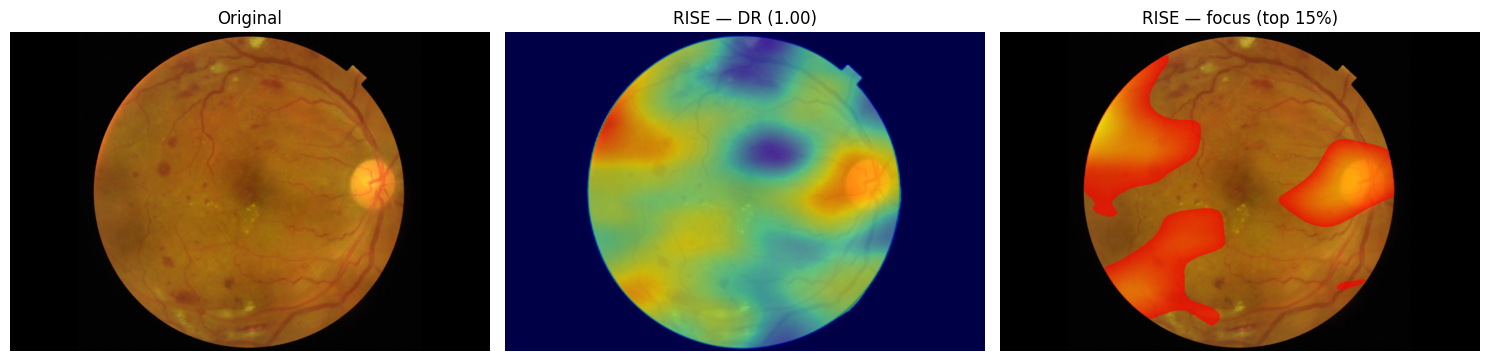

In [10]:
# ================= RISE XAI — Inception-v4 (robust masks, resized fundus mask, pretty overlays) =================
import numpy as np, pandas as pd, torch, torch.nn.functional as F, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import timm

# ---------------- Paths / config ----------------
CLASSES = ['AION','ARMD','BRVO','CRVO','DR','MHL','ERM','ODC','RPEC','DN']
NUM_CLASSES = len(CLASSES)

ROOT      = Path(r"C:\datasets\eye_project")
CKPT_PATH = ROOT / "models" / "inception_v4_best.pth"             # <-- edit if needed
TEST_CSV  = ROOT / "processed" / "splits_strict_10cls_new" / "test_local.csv"
OUT_DIR   = ROOT / "models" / "reports" / "inception_v4_rise"
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---------------- Model ----------------
model = timm.create_model("inception_v4", pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)
model.eval()
print("✅ Loaded:", CKPT_PATH)

# ---------------- Preprocessing (Inception 299) ----------------
NET_HW = (299, 299)
preproc = transforms.Compose([
    transforms.Resize(NET_HW),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

@torch.no_grad()
def predict_probs(pil_img):
    x = preproc(pil_img).unsqueeze(0).to(DEVICE)         # (1,3,299,299)
    logits = model(x)
    probs  = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    return x, probs, int(np.argmax(probs))

# ---------------- Fundus mask (resize to any target HW) ----------------
def fundus_mask_resized(pil_img, target_hw, thresh=8, sigma=4, edge=0.2):
    """
    Returns a soft mask resized to (H, W) to match a saliency map.
    """
    H, W = target_hw
    g = np.array(pil_img.convert("L"))
    m = (g > thresh).astype(np.float32)
    m = gaussian_filter(m, sigma=sigma)
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)
    m = (m > edge).astype(np.float32)  # original size
    m_small = Image.fromarray((m*255).astype(np.uint8)).resize((W, H), Image.BILINEAR)
    return (np.array(m_small).astype(np.float32) / 255.0)

# ---------------- Robust RISE mask generator ----------------
def generate_rise_masks_robust(N=800, s=7, p=0.5, input_size=(299, 299), seed=42):
    """
    Always returns array of shape (N, H, W) with float masks in [0,1].
    1) Sample s×s Bernoulli grid
    2) Bilinear resize to (H,W)
    3) Random roll (dx,dy) jitter (keeps shape identical)
    """
    rng = np.random.default_rng(seed)
    H, W = input_size
    masks = np.empty((N, H, W), dtype=np.float32)
    cell_h = max(1, H // s)
    cell_w = max(1, W // s)
    for i in range(N):
        grid = (rng.random((s, s)) < p).astype(np.float32)
        up   = resize(grid, (H, W), order=1, mode='reflect',
                      anti_aliasing=False, preserve_range=True).astype(np.float32)
        dx = rng.integers(0, cell_h)
        dy = rng.integers(0, cell_w)
        up = np.roll(up, shift=dx, axis=0)
        up = np.roll(up, shift=dy, axis=1)
        masks[i] = up
    return masks  # (N,H,W)

# ---------------- RISE (robust), batched ----------------
@torch.no_grad()
def rise_saliency_robust(pil_img, target_idx="pred",
                         N=800, s=7, p=0.5, batch_size=32,
                         blur_sigma=6, apply_fundus=True):
    """
    Returns:
      sal299: saliency at network resolution (299x299) in [0,1]
      probs : softmax probs for the image
      pred_idx: predicted class index
    """
    x, probs, pred_idx = predict_probs(pil_img)
    tgt = pred_idx if target_idx == "pred" else int(target_idx)
    H, W = x.shape[-2:]

    masks = generate_rise_masks_robust(N=N, s=s, p=p, input_size=(H, W))
    norm = 1.0 / (N * p)

    sal = np.zeros((H, W), dtype=np.float32)
    for i in range(0, N, batch_size):
        m  = masks[i:i+batch_size]                               # (B,H,W)
        mb = torch.from_numpy(m).to(x.device).unsqueeze(1)       # (B,1,H,W)
        xb = x.repeat(mb.shape[0], 1, 1, 1) * mb                 # (B,3,H,W)
        logits = model(xb)
        probs_b = F.softmax(logits, dim=1)[:, tgt].detach().cpu().numpy()  # (B,)
        sal += (m * probs_b[:, None, None]).sum(axis=0)

    sal *= norm
    sal = gaussian_filter(sal, sigma=blur_sigma)
    sal -= sal.min()
    sal /= (sal.max() + 1e-8)

    if apply_fundus:
        sal *= fundus_mask_resized(pil_img, (H, W))

    return sal, probs, pred_idx

# ---------------- Overlays ----------------
def overlay_heatmap(img_rgb_np, heat, alpha=0.55, cmap="jet", focus_top_p=None):
    """
    img_rgb_np: (H,W,3) uint8 in [0,255]
    heat: (H,W) float [0,1]
    If focus_top_p (e.g. 0.85) is set, color only top activations.
    """
    import matplotlib.cm as cm
    img = img_rgb_np.astype(np.float32)/255.0

    if focus_top_p is not None:
        thr   = np.quantile(heat, focus_top_p)
        mask  = (heat >= thr).astype(np.float32)
        heat_ = np.where(mask > 0, (heat - thr) / (heat.max() - thr + 1e-8), 0.0)
        color = cm.get_cmap(cmap)(heat_)[..., :3]
        overlay = img*(1 - (mask[...,None]*alpha)) + color*(mask[...,None]*alpha)
    else:
        color = cm.get_cmap(cmap)(heat)[..., :3]
        overlay = img*(1 - alpha) + color*alpha

    overlay = np.clip(overlay, 0, 1)
    return (overlay*255).astype(np.uint8)

# ---------------- Run on a confident sample; save triptych ----------------
test_df = pd.read_csv(TEST_CSV)
test_df["img_path"] = test_df["img_path"].apply(lambda p: str(Path(p)))

# Pick a high-confidence test image (better visual)
best_path, best_conf = None, -1.0
for _, r in test_df.sample(min(80, len(test_df)), random_state=17).iterrows():
    pil_tmp = Image.open(r["img_path"]).convert("RGB")
    _, probs_tmp, pred_tmp = predict_probs(pil_tmp)
    if probs_tmp[pred_tmp] > best_conf:
        best_conf, best_path = probs_tmp[pred_tmp], r["img_path"]

pil = Image.open(best_path).convert("RGB")
print(f"Explaining with RISE: {best_path}  (conf {best_conf:.2f})")

# ---- RISE parameters (speed vs quality) ----
N_SAMPLES  = 800    # 400-800 fast; 1500+ prettier but slower
GRID_S     = 7
PROB_KEEP  = 0.5
BATCH_SIZE = 32

# Compute saliency at network res (299x299)
sal299, probs, pred_idx = rise_saliency_robust(
    pil, target_idx="pred",
    N=N_SAMPLES, s=GRID_S, p=PROB_KEEP, batch_size=BATCH_SIZE,
    blur_sigma=6, apply_fundus=True
)
pred_lbl = CLASSES[pred_idx]; conf = probs[pred_idx]

# Upsample saliency to original fundus size for pretty overlays
orig_w, orig_h = pil.size
sal_big = Image.fromarray((sal299*255).astype(np.uint8)).resize((orig_w, orig_h), Image.BILINEAR)
sal_big = np.array(sal_big).astype(np.float32) / 255.0

img_rgb = np.array(pil)  # (H,W,3) uint8
ov_full  = overlay_heatmap(img_rgb, sal_big, alpha=0.55, cmap="jet",    focus_top_p=None)
ov_focus = overlay_heatmap(img_rgb, sal_big, alpha=0.70, cmap="autumn", focus_top_p=0.85)

# Plot: Original | RISE (full) | RISE (focus-only)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img_rgb); ax[0].axis("off"); ax[0].set_title("Original")
ax[1].imshow(ov_full); ax[1].axis("off"); ax[1].set_title(f"RISE — {pred_lbl} ({conf:.2f})")
ax[2].imshow(ov_focus); ax[2].axis("off"); ax[2].set_title("RISE — focus (top 15%)")
plt.tight_layout()

trip = OUT_DIR / f"{Path(best_path).stem}_rise_triptych.png"
plt.savefig(trip, dpi=220, bbox_inches="tight")
Image.fromarray(ov_full).save(OUT_DIR / f"{Path(best_path).stem}_rise_full.png")
Image.fromarray(ov_focus).save(OUT_DIR / f"{Path(best_path).stem}_rise_focus.png")
print("Saved:", trip)
plt.show()
